# Checking conservation of fluorescence

Loading BokehJS ...


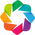

In [373]:
import numpy as np
import pandas as pd
import scipy.io
import bokeh.plotting
import bokeh.io
import holoviews as hv
import mscl_utils as mscl
import skimage.io
import scipy.signal
import skimage.segmentation
import skimage.morphology
import theano.tensor as tt
import pymc3 as pm
import glob

# Use MATLAB python API to read in files. 
import matlab.engine as matlab
try:
    eng = matlab.connect_matlab()
except:
    eng = matlab.start_matlab()
bokeh.io.output_notebook()
hv.extension('bokeh')
# Define the root directory for the experiment.
root_dir = '../data/images/20171026_sfGFP_10ngmL_dilution/'

The purpose of this notebook is to analyze a dilution growth movie in which fluorescence and phase contrast images were taken repeatedly through several rounds of cell division. To ensure that the system is working as expected, I will perform several check such as volume effects, fluorescence conservation, and photobleaching. 

In [276]:
import imp
imp.reload(mscl)

<module 'mscl_utils' from '/Users/gchure/lab/PhillipsLab201401-XXX/lab_code/mscl_analysis/mscl_utils.py'>

## Measuring the photobleaching rate constant 

In [277]:
# Load the fl
bf_im = skimage.io.imread(glob.glob('{0}delta_bleach/*Brightfield*.tif'.format(root_dir))[0])

# Flatten the image.
im_float = (bf_im - bf_im.min()) / (bf_im.max() - bf_im.min())
im_blur = skimage.filters.gaussian(im_float, sigma=10)
im_sub = im_float - im_blur

# Threshold through Otsu.
thresh = skimage.filters.threshold_otsu(im_sub)

# Clear the border 
seg = skimage.segmentation.clear_border(im_sub < thresh)

# Remove small objects.
seg = skimage.morphology.remove_small_objects(seg)
mask = skimage.measure.label(seg)

# Show the segmentation over the original image. 
contours = skimage.measure.find_contours(seg, 0)

p = mscl.bokeh_imshow(np.rot90(bf_im), plot_height=600)
for c in contours:
    p.line(c[:,0], c[:,1], color='tomato', line_width=2)
bokeh.io.show(p)

Now with a segmentation mask in place, I can measure the fluorescence information for each cell over the entire time course.

In [278]:
# Load all of the images.
delta_bleach = np.sort(glob.glob('{0}delta_bleach/*GFP*.tif'.format(root_dir)))
delta_ims = skimage.io.ImageCollection(delta_bleach)
slide_ims = skimage.io.ImageCollection('{0}*fluorescent_slide/Pos*/*.tif'.format(root_dir))
field_avg = mscl.average_stack(slide_ims)
# instantiate the bleaching dataframe.
bleach_df = pd.DataFrame([], columns=['cell_label', 'frame_number', 'total_intensity'])

for i, f in enumerate(delta_ims): 
    flat = mscl.generate_flatfield(f, field_avg, median_filt=False)
    # Compute the properties. 
    props = skimage.measure.regionprops(mask, flat)
    cell_dict = {}
    for prop in props:
        cell_dict['cell_label'] = prop.label
        cell_dict['total_intensity'] = prop.mean_intensity * prop.area
        cell_dict['frame_number'] = i 
        
        # Make a data frame.
        bleach_df = bleach_df.append(cell_dict, ignore_index=True)

In [286]:
p = mscl.bokeh_boiler(tools=['hover'], x_axis_label='frame number',
                     y_axis_label='relative intensity')
# hover = bokeh.models.HoverTool(tooltips=(('cell', '@cell_label')))
grouped = bleach_df.groupby('cell_label')
for g, d in grouped: 
    # Normalize each trace to the first 3 measurements.
    I_0 = d.iloc[5]['total_intensity'].mean()
    I_t = d['total_intensity'] / I_0
    p.line(d['frame_number'], I_t, color='slategray', alpha=0.3, 
          hover_line_color='tomato', line_width=0.25)
bokeh.io.show(p)

In [433]:
# look at just one trace.
single_cell = bleach_df.loc[bleach_df['cell_label']== 10]
I_0 = single_cell.iloc[0]['total_intensity']
I_t = single_cell['total_intensity'] 
# Smooth via savgol filtering. 
window = 15 
polyorder = 1
smoothed = scipy.signal.savgol_filter(I_t, window, polyorder)

# Show both.
p = mscl.bokeh_boiler(width=600, height=500)
p.circle(single_cell['frame_number'], I_t / I_0, color='slategray',
        legend='raw data', size=2)
p.line(single_cell['frame_number'], I_t / I_0, color='slategray',
      line_width=0.75)


# Plot the smoothed case.
p.line(single_cell['frame_number'], smoothed / I_0, color='dodgerblue', line_width=2,
      legend='SG Filter (order = {0}, window = {1})'.format(polyorder, window))
bokeh.io.show(p)

Posterior distribution should be

$$
P(\tau\,\vert\, t, I) \propto {1 \over \tau}\left(\sum\limits_{i}^{k} (I_i - I(\tau, t))^2\right)^{-k/2}
$$

where $I(\tau, t)$ is th e normalized exponential decay

$$
{I(t) \over I_0} = \exp\left[-t \over \tau\right].
$$

In [477]:
def exp_decay(time, Io, tau):
    return Io * np.exp(-time / tau)

def log_prior(tau, Io):
    if (Io < 0).any():
        return -np.inf
    if (tau <= 1E-9).any():
        return -np.inf
    else:
        return -np.log(tau)
    
def log_post(tau, Io, I, time):
    lnp = log_prior(tau, Io)
    if lnp == -np.inf:
        return -np.inf
 
    theo = exp_decay(time, Io, tau)
    
    marg_post = -0.5 * len(I) * np.log(np.sum(I - theo)**2)
    return lnp + marg_post

def neg_log_post(params, I, time):
    tau, Io = params
    return  -log_post(tau, Io, I, time)

In [481]:
p0 = np.array([0.5, 1])
args = (smoothed, single_cell['frame_number'].values)
resids = scipy.optimize.minimize(neg_log_post, p0, args=args, method='powell')
popt = resids.x
popt

array([  1.76151928e-01,   2.03221727e+07])

In [495]:
popt, junk = scipy.optimize.curve_fit(photobleaching, single_cell['frame_number'], smoothed/I_0, p0=1)
popt

frames = np.linspace(0, 500, 5000)
theo = np.exp(-frames/ 1000)
p = mscl.bokeh_boiler()
p.circle(single_cell['frame_number'], smoothed/I_0, color='slategray', legend='smoothed data')
p.line(frames, theo, color='dodgerblue', legend='fit with τ = {0} inv. s.'.format(popt[0]))
bokeh.io.show(p)

In [431]:
scipy.optimize.minimize?

In [435]:
popt

array([ 1312.97308178])

## Parsing SuperSegger `cell.mat` files

In [16]:
# Load an example file. 
pos0 = '{0}/growth/xy00/cell/'.format(root_dir)
pos0_files = glob.glob('{0}*.mat'.format(pos0))
eng.workspace['f'] = pos0_files[0]
mat = eng.eval('load(f)')

In [133]:
def cell_to_dict(file, add_props=None, excluded_props=None):
    """
    Reads a single cell file and produces a dictionary containing
    the properties of interest. 
    
    The returned properties are 
    * birth - frame number at which the cell was born.
    * death - frame number at which the cell died.
    * divide - bool for an observed cell division.
    * ID - integer ID number of the cell.
    * motherID - integer ID number of the mother cell.
    * sisterID - integer ID number of the sister cell.
    * birth_fluo - fluorescence value at the cell's birth.
    * death_fluo - fluorescence value at the cell's death.
    * daughter_1_ID - integer ID number of the first daughter.
    * daughter_2_ID - integer ID number of the second daughter.
    
    
    Parameters
    ----------
    file: str
        Path of the cell file. This must be in a `.mat` format.
    add_props : dict, default None
        Dictionary of additional properties (not found in the mat file)
        to be included in the returned dictionary.
    excluded_props: list of str
        Properties of cell.mat file to be ignored. These must be 
        exactly how they are defined in the cell file.
    
    Returns
    -------
    cell_dict : dictionary
        Dictionary of all extracted properties from the cell files. 
    """
    
    # Ensure the supplied file is actually a .mat and other types are correct. 
    if file.split('.')[-1] != 'mat':
        raise TypeError("supplied file {0} is not a `.mat` file.".format(file))
    if add_props is not None and type(add_props) is not dict:
        raise TypeError("add_props is {0} and not dict.".format(type(add_props)))                  
    if excluded_props is not None and type(excluded_props) is not list:
        raise TypeError("add_props must be list. Type is currently {0}.".format(type(excluded_props)))
                        
    # Define the values of interest.
    vals = ['birth', 'death', 'divide', 'ID', 'motherID', 'sisterID', 
             'daughter_1_ID', 'daughter_2_ID', 'birth_fluo', 'death_fluo'] 
    
    # Load the mat file using MATLAB.
    mat = scipy.io.loadmat(file, squeeze_me=True,
                      chars_as_strings=True,
                      struct_as_record=True)
    
    # Assemble the dictionary for constant properties. 
    cell_dict = {v: mat[v] for v in vals[:-4]}
    daughters = mat['daughterID']
    
    # Determine  if daughters were produced. If not, change ID to NaN.
    if len(daughters) == 0:
        daughter_1, daughter_2 = None,  None
    else:
        daughter_1, daughter_2 = daughters 
    cell_dict['daughter_1_ID'] = daughter_1
    cell_dict['daughter_2_ID'] = daughter_2
     
    # Extract fluorescence information -- This is a bit gross but checked.
    try:
        fluo = [mat['CellA'][i]['fl1'].flatten()[0].flatten()[0][0] for i, _ in enumerate(mat['CellA'])]
        nonzero = [f for f in fluo if f != 0] 
        num_exposures = len(nonzero)
        cell_dict['birth_fluo'] = nonzero[0] 
        cell_dict['death_fluo'] = nonzero[-1]
    except:
        cell_dict['birth_fluo'] = 0
        cell_dict['death_fluo'] = 0
        num_exposures = 0 
    cell_dict['num_exposures'] = num_exposures
    # Deal with exclusion and addition of props. 
    if excluded_props is not None:
        new_dict = {}
        keys = cell_dict.keys()
        for key in keys:
            if key not in excluded_props:
                new_dict[key] = cell_dict[key]
        cell_dict = new_dict
    if add_props is not None:
        for key in add_props.keys(): 
            cell_dict[key] = add_props[key]
                        
    # Return the cell dictionary.
    return cell_dict

def parse_cell_files(files, **kwargs):
    """
    Executes cell_to_dict across a list of files and returns a Pandas DataFrame.
    """
    if type(files) is not list:
        raise TypeError("'files' is type {0} not list.".format(type(files)))
    for i, f in enumerate(files):
        cell_dict = cell_to_dict(f, **kwargs)  
        if i == 0:
            keys = cell_dict.keys()
            df = pd.DataFrame([], columns=keys)
            df = df.append(cell_dict, ignore_index=True)
        else:
            df = df.append(cell_dict, ignore_index=True)
    return df            

Compute the autofluorescence distribution

In [134]:
# Define the directory containing the autofluorescence samples. 
auto_dir = '{0}auto/xy*'.format(root_dir)
auto_positions = glob.glob(auto_dir)

# Loop through each position and parse the cell files. 
auto_dfs = []
for i, pos in enumerate(auto_positions):
    # Get the positition number. 
    num = int(pos.split('xy')[-1])
    
    # Glob the cell files and generate the Datarame.
    files = glob.glob('{0}/cell/*.mat'.format(pos))
    _df = parse_cell_files(files, add_props={'position': int(num)},
                          excluded_props=['daughter_1_ID', 'daughter_2_ID',
                                          'death_fluo', 'motherID',
                                          'sisterID','divide', 'birth', 'death'])
    auto_dfs.append(_df)
    
# Assemble all of the positions into a single DataFrame
auto_df = pd.concat(auto_dfs, axis=0)

# Compute the mean autofluorescence value. 
mean_auto = auto_df['birth_fluo'].mean()
print('The mean autofluorescence is {0:.2f} a.u. per cell.'.format(mean_auto))

The mean autofluorescence is 57556.51 a.u. per cell.


In [150]:
x, y = mscl.ecdf(auto_df['birth_fluo'])
p = mscl.bokeh_boiler(x_axis_label='total cell fluorescence (a.u.)',
                     y_axis_label='ECDF')
p.circle(x, y, color='dodgerblue', size=3, alpha=0.75)
bokeh.io.show(p)

Parse all position files 

In [137]:
# Assemble the entire DataFrame.
data_dir = '{0}growth/xy*'.format(root_dir)

# Grab all of the positions.
positions = glob.glob(data_dir)

# Loop through each position and generate the DataFrame.
for i, pos in enumerate(positions):
    # Figure out the position number.
    num = int(pos.split('xy')[-1])
    
    # Grab all of the files.
    files = glob.glob('{0}/cell/*.mat'.format(pos))
    
    # Generate the DataFrame.
    _df = parse_cell_files(files, add_props={'position': num})
    if i == 0:
        df = _df
    else:
        df = df.append(_df, ignore_index=True) 

In [139]:
# Restrict data frame to only those that divided or died on last frame. 
producers = df[(df['divide'] == 1) | (df['death']==37)].copy()

# Remove anomolous zeros.
measured = producers.loc[(producers['birth_fluo'] > 0) & (producers['death_fluo'] > 0)]

Group by the mother ID's  and position and look at the conservation of fluorescence. 

In [288]:
grouped = measured.groupby(['position', 'motherID'])
# Iterate through and compute the total fluorescence and mother fluorescence.

summed = []
mother = []
for g, d in grouped:
    mother_fluo = (measured[(measured['ID']==g[1]) & (measured['position']==g[0])]['death_fluo']).sum()
    if mother_fluo != 0:
        mother.append(mother_fluo)
        summed.append(np.sum(d['birth_fluo']))

In [317]:
# compute the expected linear trend.
theo = np.linspace(np.min(mother), np.max(mother), 300)
p = mscl.bokeh_boiler()
p.circle(mother, summed, color='slategray', alpha=0.5, legend='data',
        size=1)
p.line(theo, theo, color='dodgerblue', line_width=2, legend='conserved fluorescence')
bokeh.io.show(p)

## Measuring the fluctuations. 

In [307]:
dilution_df = pd.DataFrame([], columns=['sum_total', 'sq_diff'])
for g, d in grouped:
    if len(d) == 2:
        sum_total = d['death_fluo'].sum()
        sq_diff = (np.diff(d['death_fluo'])**2)[0]
        dilution_df = dilution_df.append(dict(sum_total=sum_total,
                                             sq_diff=sq_diff), ignore_index=True)

In [314]:
# Bin the data to compute the means. 
bin_width = 50
bins = np.arange(0, len(dilution_df) + bin_width, bin_width)
sum_total_means, sq_diff_means = [], []
dilution_df.sort_values(by=['sum_total'], inplace=True)
for i in range(1, len(bins)):
    slc = dilution_df.iloc[bins[i-1]: bins[i] + 1]
    sum_total_means.append(slc['sum_total'].mean())
    sq_diff_means.append(slc['sq_diff'].mean())
  

# Plot the raw data and the computed means.
p = mscl.bokeh_boiler(x_axis_type='log', y_axis_type='log',
                     x_axis_label='I\u2081 + I\u2082',
                     y_axis_label='(I\u2081 + I\u2082)\u00B2')
p.circle(dilution_df['sum_total'], dilution_df['sq_diff'], 
         color='slategray', alpha=0.5, size=2, legend='data')
p.circle(sum_total_means, sq_diff_means, color='tomato', size=4,
         legend='avg. of {0} measurements'.format(bin_width))

p.legend.location = 'bottom_right'
bokeh.io.show(p)